<a href="https://colab.research.google.com/github/arohanajit/script-detection/blob/main/script_generation_PyTorch_98_5_acc_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install necessary libraries
!pip install pytorch-model-summary
import csv 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from pytorch_model_summary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import shutil

In [ ]:

%%capture
#Use loader to import data from kaggle
if 'loader.py' not in os.listdir():
    !wget https://raw.githubusercontent.com/arohanajit/disease-detector/master/loader.py
import loader
if 'data' not in os.listdir():
    loader.load_data()
    !kaggle datasets download -d arohanajit232/gurmukhidataset
    !unzip gurmukhidataset.zip
    !rm gurmukhidataset.zip
    shutil.rmtree('data/Python code')

In [ ]:
# Basic resizing, normalization and type conversion of data to tensor for processing
data_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Division into test and train
data_dir = 'data/'
data = datasets.ImageFolder(data_dir,transform=data_transforms)
test_size = 0.2
print(len(data))
class_labels = list(data.class_to_idx.keys())
print(class_labels)

22349
['Amritsar', 'Barnala', 'Bathinda', 'Faridkot', 'Fathegarh Sahib', 'Fazilka', 'Firozpur', 'Gurdaspur', 'Hoshairpur', 'Jalandhar', 'Kapurthala', 'Ludhiana', 'Mansa', 'Moga', 'Mohali', 'Muktsar', 'Nawanshahar', 'Pathankot', 'Ropar', 'Sangrur', 'Taran Taaran', 'patiala']


In [ ]:
# Random sample and batch distribution for Batch GD and bias removal
num_train = len(data)
indices = list(range(num_train))
np.random.shuffle(indices)
test_split = int(np.floor((test_size) * num_train))
test_idx, train_idx = indices[:test_split], indices[test_split:]

print(len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {
    'train' : len(train_idx),
    'test' : len(test_idx)
}

loaders = {
    'train': torch.utils.data.DataLoader(data, batch_size=64, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(data, batch_size=32, sampler=test_sampler),
}

4469 17880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([64, 3, 256, 256]) torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


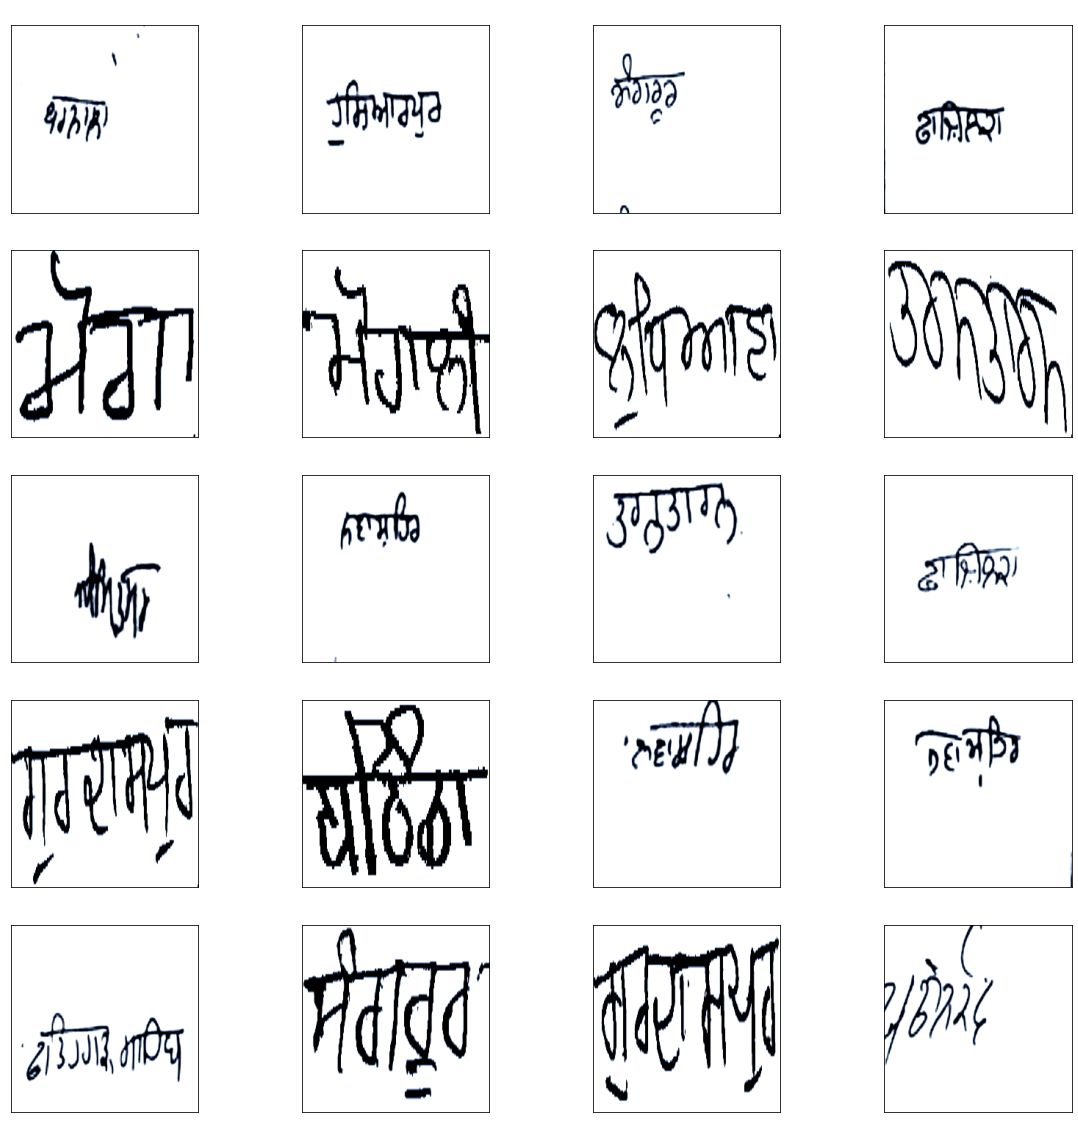

In [ ]:
#Display some images with labels
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(loaders['train'])
images, labels = dataiter.next()
print(images.shape,labels.shape)
images = images.numpy() 
fig = plt.figure(figsize=(20, 20))

for idx in np.arange(20):
    ax = fig.add_subplot(5, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_labels[int(labels[idx])],fontsize=15,color='white')

In [ ]:
#Graphing train and test loss
def graph_loss(train_loss,test_loss):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(train_loss)
    ax.plot(test_loss)
    ax.legend(['Train Loss','Test Loss'])

In [ ]:
#Function to train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loss_data = {'epoch':[],'train':[],'test':[]}
    accuracy_data = {'epoch':[],'train':[],'test':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_data['epoch'].append(epoch)
                accuracy_data['epoch'].append(epoch)
                loss_data['train'].append(epoch_loss)
                accuracy_data['train'].append(epoch_acc)
            else:
                loss_data['test'].append(epoch_loss)
                accuracy_data['test'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    graph_loss(loss_data['train'], loss_data['test'])

    pd.DataFrame.from_dict(loss_data).to_csv('loss.csv')
    pd.DataFrame.from_dict(accuracy_data).to_csv('accuracy.csv')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Function to visualise model results
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in loaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            fig = plt.figure(figsize=(15, 15))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} actual: {}'.format(class_labels[preds[j]], class_labels[labels.cpu().data[j]]),fontsize=10,color='white')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Define pretrained transfer learning model
model_ft = models.densenet201(pretrained=True)

# Selection model paramters
#Freezing model layers
for params in model_ft.parameters():
    params.requires_grad = False

#Defining classifiers
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_labels))

# Unfreezing bottom layers
for name,params in zip(model_ft.features.denseblock4,model_ft.features.denseblock4.parameters()):
    if int(name[10:]) >= 26:
        params.requires_grad = True

#Summary of model and transfer to GPU
print(summary(model_ft, torch.zeros((1, 3, 256, 256))))
model_ft = model_ft.to(device)

#Optimisation
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth



-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 128, 128]           9,408               0
     BatchNorm2d-2     [1, 64, 128, 128]             128               0
            ReLU-3     [1, 64, 128, 128]               0               0
       MaxPool2d-4       [1, 64, 64, 64]               0               0
     _DenseBlock-5      [1, 256, 64, 64]         335,040               0
     BatchNorm2d-6      [1, 256, 64, 64]             512               0
            ReLU-7      [1, 256, 64, 64]               0               0
          Conv2d-8      [1, 128, 64, 64]          32,768               0
       AvgPool2d-9      [1, 128, 32, 32]               0               0
    _DenseBlock-10      [1, 512, 32, 32]         919,680               0
    BatchNorm2d-11      [1, 512, 32, 32]           1,024               0
           ReLU-12      [1, 512, 32, 32]         

In [ ]:
#Training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.9785 Acc: 0.7254
test Loss: 0.3396 Acc: 0.8921

Epoch 2/10
----------
train Loss: 0.2260 Acc: 0.9294


In [ ]:
#Visualization
visualize_model(model_ft)

In [ ]:
#Save model
torch.save(model_ft,'model.pt')